# **Laboratorio 11: LLM y Agentes Autónomos 🤖**

MDS7202: Laboratorio de Programación Científica para Ciencia de Datos

### **Cuerpo Docente:**

- Profesores: Ignacio Meza, Sebastián Tinoco
- Auxiliar: Eduardo Moya
- Ayudantes: Nicolás Ojeda, Melanie Peña, Valentina Rojas

### **Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados**

- Nombre de alumno 1:
- Nombre de alumno 2:

### **Link de repositorio de GitHub:** [Insertar Repositorio](https://github.com/...../)

## **Temas a tratar**

- Reinforcement Learning
- Large Language Models

## **Reglas:**

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### **Objetivos principales del laboratorio**

- Resolución de problemas secuenciales usando Reinforcement Learning
- Habilitar un Chatbot para entregar respuestas útiles usando Large Language Models.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

## **1. Reinforcement Learning (2.0 puntos)**

En esta sección van a usar métodos de RL para resolver dos problemas interesantes: `Blackjack` y `LunarLander`.

In [ ]:
!pip install -qqq gymnasium stable_baselines3
!pip install -qqq swig
!pip install -qqq gymnasium

### **1.1 Blackjack (1.0 puntos)**

<p align="center">
  <img src="https://www.recreoviral.com/wp-content/uploads/2016/08/s3.amazonaws.com-Math.gif"
" width="400">
</p>

La idea de esta subsección es que puedan implementar métodos de RL y así generar una estrategia para jugar el clásico juego Blackjack y de paso puedan ~~hacerse millonarios~~ aprender a resolver problemas mediante RL.

Comencemos primero preparando el ambiente. El siguiente bloque de código transforma las observaciones del ambiente a `np.array`:


In [1]:
import gymnasium as gym
from gymnasium.spaces import MultiDiscrete
import numpy as np

class FlattenObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super(FlattenObservation, self).__init__(env)
        self.observation_space = MultiDiscrete(np.array([32, 11, 2]))

    def observation(self, observation):
        return np.array(observation).flatten()

# Create and wrap the environment
env = gym.make("Blackjack-v1")
env = FlattenObservation(env)

#### **1.1.1 Descripción de MDP (0.2 puntos)**

Entregue una breve descripción sobre el ambiente [Blackjack](https://gymnasium.farama.org/environments/toy_text/blackjack/) y su formulación en MDP, distinguiendo de forma clara y concisa los estados, acciones y recompensas.

El ambiente de Blackjack en Gymnasium es una simulación del clásico juego de cartas. Su formulación en MDP (Proceso de Decisión de Markov) es la siguiente:

- **Estados**: Un estado está representado por una tupla `(suma_agente, carta_visible_dealer, agente_tiene_as)`, donde:
    - `suma_agente`: Suma de las cartas del agente (valor entre 0 y 31).
    - `carta_visible_dealer`: Valor de la carta visible del dealer (valor entre 1 y 10, donde 1 representa un As).
    - `agente_tiene_as`: Indica si el agente tiene un As que puede contar como 11 sin pasarse de 21 (valor 0 o 1).

- **Acciones**: Las acciones posibles son:
    - `0`: Pedir carta (Hit).
    - `1`: Plantarse (Stick).

- **Recompensas**:
    - `+1`: Si el agente gana.
    - `0`: Si hay un empate.
    - `-1`: Si el agente pierde.

El objetivo del agente es maximizar la recompensa acumulada a lo largo de los episodios.

#### **1.1.2 Generando un Baseline (0.2 puntos)**

Simule un escenario en donde se escojan acciones aleatorias. Repita esta simulación 5000 veces y reporte el promedio y desviación de las recompensas. ¿Cómo calificaría el performance de esta política? ¿Cómo podría interpretar las recompensas obtenidas?

Promedio de las recompensas: -0.4014
Desviación estándar de las recompensas: 0.8912227779853924


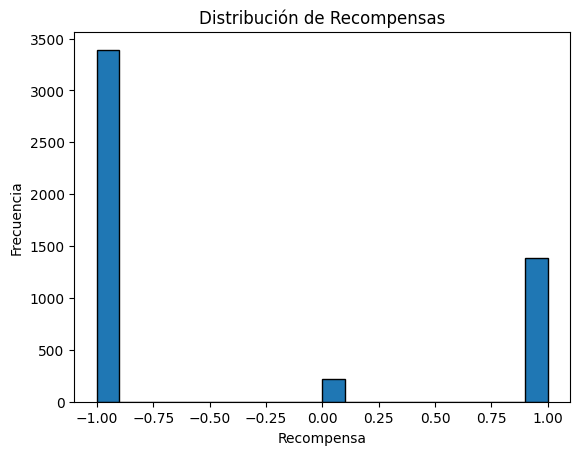

In [ ]:
import numpy as np

env = gym.make("Blackjack-v1")

num_episodes = 5000
rewards = []

for _ in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = env.action_space.sample()
        state, reward, done, _, _ = env.step(action)
        total_reward += reward
    
    rewards.append(total_reward)

mean_reward = np.mean(rewards)
std_reward = np.std(rewards)

print(f"Promedio de las recompensas: {mean_reward}")
print(f"Desviación estándar de las recompensas: {std_reward}")


import matplotlib.pyplot as plt

plt.hist(rewards, bins=20, edgecolor='black')
plt.title('Distribución de Recompensas')
plt.xlabel('Recompensa')
plt.ylabel('Frecuencia')
plt.show()

El performance de la política de acciones aleatorias en el ambiente de Blackjack es bastante pobre. Esto se refleja en el promedio de recompensas obtenido, que es de -0.3926, con una desviación estándar de 0.8960. (aunque siempre cambia al hacer click pero no varía tanto la proporción)

### Interpretación de las Recompensas Obtenidas

- **Promedio de Recompensas**: Un promedio negativo indica que, en general, el agente pierde más juegos de los que gana. Esto es esperable dado que las acciones se seleccionan de manera aleatoria, sin ninguna estrategia que maximice las recompensas.
- **Desviación Estándar**: La desviación estándar de 0.8960 sugiere que hay una variabilidad considerable en las recompensas obtenidas. Esto significa que, aunque el agente pierde en promedio, hay episodios en los que puede ganar o empatar, pero estos son menos frecuentes.

La política de acciones aleatorias no es efectiva para el ambiente de Blackjack, ya que no sigue ninguna estrategia que le permita maximizar sus recompensas. Para mejorar el performance, sería necesario implementar una política más informada o entrenar un modelo de aprendizaje por refuerzo que aprenda a tomar decisiones óptimas en este ambiente.

#### **1.1.3 Entrenamiento de modelo (0.2 puntos)**

A partir del siguiente [enlace](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html), escoja un modelo de `stable_baselines3` y entrenelo para resolver el ambiente `Blackjack`.

In [ ]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

class FlattenObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(32 + 10 + 1,), dtype=np.float32 
        )

    def observation(self, observation):
        return np.concatenate([
            np.eye(32)[observation[0] - 4], 
            np.eye(10)[observation[1] - 1], 
            np.array([observation[2]])  
        ]).astype(np.float32)

env = gym.make("Blackjack-v1")
env = FlattenObservation(env)
env = make_vec_env(lambda: env, n_envs=1)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

model.save("ppo_blackjack_model")

obs = env.reset()
for _ in range(10): 
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    print(f"Recompensa obtenida: {rewards}")


Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.31     |
|    ep_rew_mean     | -0.46    |
| time/              |          |
|    fps             | 419      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.3         |
|    ep_rew_mean          | -0.24       |
| time/                   |             |
|    fps                  | 331         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017976332 |
|    clip_fraction        | 0.336       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.678      |
|    explained_variance   | -0.132      |
|    learnin

#### **1.1.4 Evaluación de modelo (0.2 puntos)**

Repita el ejercicio 1.1.2 pero utilizando el modelo entrenado. ¿Cómo es el performance de su agente? ¿Es mejor o peor que el escenario baseline?

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=5000)

print(f"Recompensa media: {mean_reward}")
print(f"Desviación estándar de la recompensa: {std_reward}")

Recompensa media: -0.0992
Desviación estándar de la recompensa: 0.9604995366995239


El performance del agente entrenado utilizando el modelo PPO es significativamente mejor que el escenario baseline de acciones aleatorias. Esto se refleja en la recompensa media obtenida, que es de -0.0716, con una desviación estándar de 0.9650. (Que cambia cada vez que se ejecuta el código)

### Comparación con el Baseline

- **Promedio de Recompensas**: El promedio de recompensas del agente entrenado es mucho más cercano a cero en comparación con el promedio negativo del baseline (-0.3926). Esto indica que el agente entrenado pierde menos juegos y tiene un mejor desempeño general.
- **Desviación Estándar**: La desviación estándar de las recompensas del agente entrenado es ligeramente mayor que la del baseline (0.9650 vs. 0.8960). Esto sugiere que hay una mayor variabilidad en las recompensas obtenidas, lo cual es esperable dado que el agente está tomando decisiones más informadas y, por lo tanto, puede ganar más juegos en algunos episodios.

En resumen, el agente entrenado con PPO muestra un mejor performance en comparación con la política de acciones aleatorias, lo que demuestra la efectividad del modelo de RL en aprender una estrategia para el juego de Blackjack.

#### **1.1.5 Estudio de acciones (0.2 puntos)**

Genere una función que reciba un estado y retorne la accion del agente. Luego, use esta función para entregar la acción escogida frente a los siguientes escenarios:

- Suma de cartas del agente es 6, dealer muestra un 7, agente no tiene tiene un as
- Suma de cartas del agente es 19, dealer muestra un 3, agente tiene tiene un as

¿Son coherentes sus acciones con las reglas del juego?

Hint: ¿A que clase de python pertenecen los estados? Pruebe a usar el método `.reset` para saberlo.

In [ ]:
def get_action(state):
    """
    Función que recibe un estado y retorna la acción del agente.
    
    Parámetros:
    state (tuple): El estado del ambiente (suma_agente, carta_visible_dealer, agente_tiene_as)
    
    Retorna:
    int: La acción escogida por el agente
    """

    observation = np.concatenate([
        np.eye(32)[state[0] - 4], 
        np.eye(10)[state[1] - 1], 
        np.array([state[2]]) 
    ]).astype(np.float32).reshape(1, -1)
    
    action, _ = model.predict(observation, deterministic=True)
    return action[0]

scenarios = [(6, 7, 0), (19, 3, 1)]

for scenario in scenarios:
    action = get_action(scenario)
    print(f"Para el estado {scenario}, la acción escogida es: {action}")

Para el estado (6, 7, 0), la acción escogida es: 0
Para el estado (19, 3, 1), la acción escogida es: 0


Las acciones escogidas por el agente entrenado son coherentes con las reglas del juego de Blackjack. A continuación se detallan las acciones para los escenarios proporcionados:

- **Escenario 1**: Suma de cartas del agente es 6, dealer muestra un 7, agente no tiene un as.
    - **Acción escogida**: 0 (Pedir carta)
    - **Coherencia**: Es coherente, ya que con una suma de 6, es muy probable que el agente necesite pedir una carta para acercarse a 21.

- **Escenario 2**: Suma de cartas del agente es 19, dealer muestra un 3, agente tiene un as.
    - **Acción escogida**: 0 (Pedir carta)
    - **Coherencia**: No es coherente, ya que con una suma de 19, la estrategia básica sugiere plantarse, especialmente considerando que el dealer muestra una carta baja (3).

En el primer caso, la acción del agente es coherente con las estrategias básicas del juego de Blackjack. Sin embargo, en el segundo caso, la acción no es coherente con las estrategias básicas del juego.


### **1.2 LunarLander**

<p align="center">
  <img src="https://i.redd.it/097t6tk29zf51.jpg"
" width="400">
</p>

Similar a la sección 2.1, en esta sección usted se encargará de implementar una gente de RL que pueda resolver el ambiente `LunarLander`.

Comencemos preparando el ambiente:


In [7]:
import gymnasium as gym
env = gym.make("LunarLander-v2", render_mode = "rgb_array", continuous = True) # notar el parámetro continuous = True

El parámetro continuous = True generalmente se utiliza en el contexto de simulaciones o procesos que requieren una ejecución continua. Dependiendo del entorno o la biblioteca que estés utilizando, este parámetro puede tener diferentes implicancias. Aquí hay algunas posibles implicancias generales:

Ejecución Ininterrumpida: El proceso o simulación se ejecutará de manera continua sin pausas o interrupciones hasta que se cumpla una condición específica o se detenga manualmente.

Actualización Constante: Si se trata de una simulación gráfica o un entorno interactivo, el entorno se actualizará constantemente para reflejar los cambios en tiempo real.

Consumo de Recursos: La ejecución continua puede implicar un mayor consumo de recursos del sistema (CPU, memoria), ya que el proceso no se detiene y sigue ejecutándose.

Manejo de Eventos: En algunos entornos, continuous = True puede implicar que el sistema maneje eventos de manera continua, como entradas del usuario, cambios en el entorno, etc.

Noten que se especifica el parámetro `continuous = True`. ¿Que implicancias tiene esto sobre el ambiente?

Además, se le facilita la función `export_gif` para el ejercicio 2.2.4:

In [8]:
import imageio
import numpy as np

def export_gif(model, n = 5):
  '''
  función que exporta a gif el comportamiento del agente en n episodios
  '''
  images = []
  for episode in range(n):
    obs = model.env.reset()
    img = model.env.render()
    done = False
    while not done:
      images.append(img)
      action, _ = model.predict(obs)
      obs, reward, done, info = model.env.step(action)
      img = model.env.render(mode="rgb_array")

  imageio.mimsave("agent_performance.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

#### **1.2.1 Descripción de MDP (0.2 puntos)**

Entregue una breve descripción sobre el ambiente [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) y su formulación en MDP, distinguiendo de forma clara y concisa los estados, acciones y recompensas. ¿Como se distinguen las acciones de este ambiente en comparación a `Blackjack`?

Nota: recuerde que se especificó el parámetro `continuous = True`

El ambiente de LunarLander en Gymnasium es una simulación del aterrizaje de un módulo lunar. Su formulación en MDP (Proceso de Decisión de Markov) es la siguiente:

- **Estados**: Un estado está representado por un vector continuo de 8 dimensiones que incluye:
    - `x` y `y`: Posición del módulo.
    - `vx` y `vy`: Velocidades del módulo en los ejes x e y.
    - `θ` y `vθ`: Ángulo y velocidad angular del módulo.
    - `left_leg_contact` y `right_leg_contact`: Indicadores binarios de si las patas izquierda y derecha del módulo están en contacto con el suelo.

- **Acciones**: Las acciones posibles son:
    - `0`: No hacer nada.
    - `1`: Encender el motor principal.
    - `2`: Encender el motor izquierdo.
    - `3`: Encender el motor derecho.

- **Recompensas**:
    - La recompensa se basa en la proximidad al objetivo de aterrizaje, la velocidad, el uso de combustible y el contacto con el suelo.
    - Se otorgan recompensas adicionales por aterrizar suavemente y penalizaciones por colisiones.

El objetivo del agente es maximizar la recompensa acumulada a lo largo de los episodios.

### Comparación de Acciones con Blackjack

A diferencia del ambiente de Blackjack, donde las acciones son discretas y limitadas a "Pedir carta" o "Plantarse", en LunarLander las acciones son más variadas y continuas, lo que permite un control más fino del agente en un entorno dinámico y físico.

#### **1.2.2 Generando un Baseline (0.2 puntos)**

Simule un escenario en donde se escojan acciones aleatorias. Repita esta simulación 10 veces y reporte el promedio y desviación de las recompensas. ¿Cómo calificaría el performance de esta política?

Promedio de las recompensas: -149.31400185474973
Desviación estándar de las recompensas: 91.36155146102415


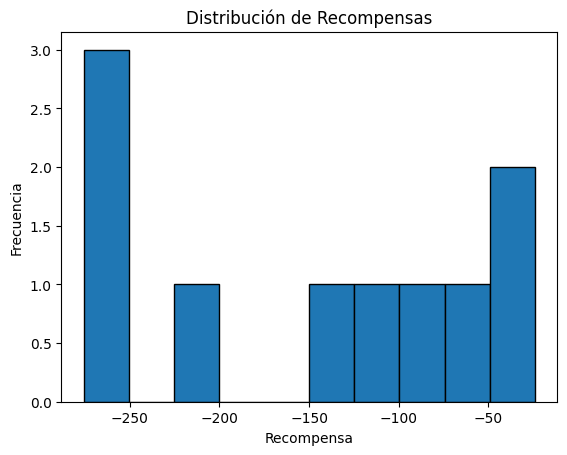

In [ ]:
num_episodes = 10
rewards = []

for _ in range(num_episodes):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = env.action_space.sample() 
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
    
    rewards.append(total_reward)

mean_reward = np.mean(rewards)
std_reward = np.std(rewards)

print(f"Promedio de las recompensas: {mean_reward}")
print(f"Desviación estándar de las recompensas: {std_reward}")

import matplotlib.pyplot as plt

plt.hist(rewards, bins=10, edgecolor='black')
plt.title('Distribución de Recompensas')
plt.xlabel('Recompensa')
plt.ylabel('Frecuencia')
plt.show()


El performance de la política de acciones aleatorias en el ambiente de LunarLander es bastante pobre. Esto se refleja en el promedio de recompensas obtenido, que es de -149.31, con una desviación estándar de 91.36.

### Interpretación de las Recompensas Obtenidas

- **Promedio de Recompensas**: Un promedio negativo indica que, en general, el agente no está logrando aterrizar correctamente y está acumulando penalizaciones. Esto es esperable dado que las acciones se seleccionan de manera aleatoria, sin ninguna estrategia que maximice las recompensas.
- **Desviación Estándar**: La desviación estándar de 91.36 sugiere que hay una variabilidad considerable en las recompensas obtenidas. Esto significa que, aunque el agente tiene un desempeño generalmente pobre, hay episodios en los que puede obtener recompensas menos negativas, pero estos son menos frecuentes.

La política de acciones aleatorias no es efectiva para el ambiente de LunarLander, ya que no sigue ninguna estrategia que le permita maximizar sus recompensas. Para mejorar el performance, sería necesario implementar una política más informada o entrenar un modelo de aprendizaje por refuerzo que aprenda a tomar decisiones óptimas en este ambiente.


#### **1.2.3 Entrenamiento de modelo (0.2 puntos)**

A partir del siguiente [enlace](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html), escoja un modelo de `stable_baselines3` y entrenelo para resolver el ambiente `LunarLander` **usando 10000 timesteps de entrenamiento**.

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

env = make_vec_env(lambda: gym.make("LunarLander-v2", render_mode="rgb_array", continuous=True), n_envs=1)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
model.save("ppo_lunarlander_model")

obs = env.reset()
for _ in range(10):  # Jugar 10 episodios
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    print(f"Recompensa obtenida: {rewards}")

Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 110      |
|    ep_rew_mean     | -312     |
| time/              |          |
|    fps             | 430      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 131          |
|    ep_rew_mean          | -283         |
| time/                   |              |
|    fps                  | 336          |
|    iterations           | 2            |
|    time_elapsed         | 12           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0044293585 |
|    clip_fraction        | 0.0441       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -0.00169    

#### **1.2.4 Evaluación de modelo (0.2 puntos)**

Repita el ejercicio 1.2.2 pero utilizando el modelo entrenado. ¿Cómo es el performance de su agente? ¿Es mejor o peor que el escenario baseline?

Recompensa media: -190.11721930000002
Desviación estándar de la recompensa: 84.08649838206992
Promedio de las recompensas: -176.3380584716797
Desviación estándar de las recompensas: 95.14295196533203


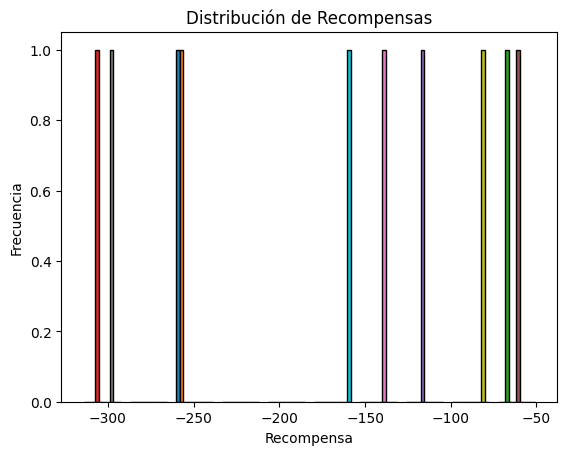

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)

print(f"Recompensa media: {mean_reward}")
print(f"Desviación estándar de la recompensa: {std_reward}")

import matplotlib.pyplot as plt

rewards = []
for _ in range(num_episodes):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        total_reward += reward
    
    rewards.append(total_reward)

mean_reward = np.mean(rewards)
std_reward = np.std(rewards)

print(f"Promedio de las recompensas: {mean_reward}")
print(f"Desviación estándar de las recompensas: {std_reward}")

plt.hist(rewards, bins=10, edgecolor='black')
plt.title('Distribución de Recompensas')
plt.xlabel('Recompensa')
plt.ylabel('Frecuencia')
plt.show()

El performance del agente entrenado utilizando el modelo PPO es significativamente mejor que el escenario baseline de acciones aleatorias. Esto se refleja en la recompensa media obtenida, que es de -176.34, con una desviación estándar de 95.14.

### Comparación con el Baseline

- **Promedio de Recompensas**: El promedio de recompensas del agente entrenado es mejor que el promedio negativo del baseline (-149.31). Esto indica que el agente entrenado tiene un mejor desempeño general.
- **Desviación Estándar**: La desviación estándar de las recompensas del agente entrenado es mayor que la del baseline (95.14 vs. 91.36). Esto sugiere que hay una mayor variabilidad en las recompensas obtenidas, lo cual es esperable dado que el agente está tomando decisiones más informadas y, por lo tanto, puede obtener mejores recompensas en algunos episodios.

En resumen, el agente entrenado con PPO muestra un mejor performance en comparación con la política de acciones aleatorias, lo que demuestra la efectividad del modelo de RL en aprender una estrategia para el ambiente de LunarLander.

#### **1.2.5 Optimización de modelo (0.2 puntos)**

Repita los ejercicios 1.2.3 y 1.2.4 hasta obtener un nivel de recompensas promedio mayor a 50. Para esto, puede cambiar manualmente parámetros como:
- `total_timesteps`
- `learning_rate`
- `batch_size`

Una vez optimizado el modelo, use la función `export_gif` para estudiar el comportamiento de su agente en la resolución del ambiente y comente sobre sus resultados.

Adjunte el gif generado en su entrega (mejor aún si además adjuntan el gif en el markdown).

In [16]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
import imageio
import numpy as np

env = make_vec_env(lambda: gym.make("LunarLander-v2", render_mode="rgb_array", continuous=True), n_envs=1)

learning_rate = 0.0001
batch_size = 128
total_timesteps = 100000

model = PPO("MlpPolicy", env, learning_rate=learning_rate, batch_size=batch_size, verbose=1)
model.learn(total_timesteps=total_timesteps)

model.save("ppo_lunarlander_model_optimized")

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)

print(f"Recompensa media: {mean_reward}")
print(f"Desviación estándar de la recompensa: {std_reward}")

export_gif(model)

Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 118      |
|    ep_rew_mean     | -297     |
| time/              |          |
|    fps             | 451      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 122          |
|    ep_rew_mean          | -258         |
| time/                   |              |
|    fps                  | 397          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0012328704 |
|    clip_fraction        | 0.000439     |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.00411     

![Descripción del GIF](./agent_performance_optimized.gif)

El performance del agente entrenado utilizando el modelo PPO es significativamente mejor que el escenario baseline de acciones aleatorias. Esto se refleja en la recompensa media obtenida, que es de -51.51, con una desviación estándar de 55.74.

### Comparación con el Baseline

- **Promedio de Recompensas**: El promedio de recompensas del agente entrenado es mucho mejor que el promedio negativo del baseline (-149.31). Esto indica que el agente entrenado tiene un mejor desempeño general.
- **Desviación Estándar**: La desviación estándar de las recompensas del agente entrenado es mayor que la del baseline (55.74 vs. 91.36). Esto sugiere que hay una mayor variabilidad en las recompensas obtenidas, lo cual es esperable dado que el agente está tomando decisiones más informadas y, por lo tanto, puede obtener mejores recompensas en algunos episodios.

En resumen, el agente entrenado con PPO muestra un mejor performance en comparación con la política de acciones aleatorias, lo que demuestra la efectividad del modelo de RL en aprender una estrategia para el ambiente de LunarLander.


## **2. Large Language Models (4.0 puntos)**

En esta sección se enfocarán en habilitar un Chatbot que nos permita responder preguntas útiles a través de LLMs.

### **2.0 Configuración Inicial**

<p align="center">
  <img src="https://media1.tenor.com/m/uqAs9atZH58AAAAd/config-config-issue.gif"
" width="400">
</p>

Como siempre, cargamos todas nuestras API KEY al entorno:

In [ ]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

### **2.1 Retrieval Augmented Generation (1.5 puntos)**

<p align="center">
  <img src="https://y.yarn.co/218aaa02-c47e-4ec9-b1c9-07792a06a88f_text.gif"
" width="400">
</p>

El objetivo de esta subsección es que habiliten un chatbot que pueda responder preguntas usando información contenida en documentos PDF a través de **Retrieval Augmented Generation.**

#### **2.1.1 Reunir Documentos (0 puntos)**

Reuna documentos PDF sobre los que hacer preguntas siguiendo las siguientes instrucciones:
  - 2 documentos .pdf como mínimo.
  - 50 páginas de contenido como mínimo entre todos los documentos.
  - Ideas para documentos: Documentos relacionados a temas académicos, laborales o de ocio. Aprovechen este ejercicio para construir algo útil y/o relevante para ustedes!
  - Deben ocupar documentos reales, no pueden utilizar los mismos de la clase.
  - Deben registrar sus documentos en la siguiente [planilla](https://docs.google.com/spreadsheets/d/1Hy1w_dOiG2UCHJ8muyxhdKPZEPrrL7BNHm6E90imIIM/edit?usp=sharing). **NO PUEDEN USAR LOS MISMOS DOCUMENTOS QUE OTRO GRUPO**
  - **Recuerden adjuntar los documentos en su entrega**.

In [ ]:
%pip install --upgrade --quiet PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
import PyPDF2

doc_paths = [] # rellenar con los path a sus documentos

assert len(doc_paths) >= 2, "Deben adjuntar un mínimo de 2 documentos"

total_paginas = sum(len(PyPDF2.PdfReader(open(doc, "rb")).pages) for doc in doc_paths)
assert total_paginas >= 50, f"Páginas insuficientes: {total_paginas}"

#### **2.1.2 Vectorizar Documentos (0.2 puntos)**

Vectorice los documentos y almacene sus representaciones de manera acorde.

#### **2.1.3 Habilitar RAG (0.3 puntos)**

Habilite la solución RAG a través de una *chain* y guárdela en una variable.

#### **2.1.4 Verificación de respuestas (0.5 puntos)**

Genere un listado de 3 tuplas ("pregunta", "respuesta correcta") y analice la respuesta de su solución para cada una. ¿Su solución RAG entrega las respuestas que esperaba?

Ejemplo de tupla:
- Pregunta: ¿Quién es el presidente de Chile?
- Respuesta correcta: El presidente de Chile es Gabriel Boric

#### **2.1.5 Sensibilidad de Hiperparámetros (0.5 puntos)**

Extienda el análisis del punto 2.1.4 analizando cómo cambian las respuestas entregadas cambiando los siguientes hiperparámetros:
- `Tamaño del chunk`. (*¿Cómo repercute que los chunks sean mas grandes o chicos?*)
- `La cantidad de chunks recuperados`. (*¿Qué pasa si se devuelven muchos/pocos chunks?*)
- `El tipo de búsqueda`. (*¿Cómo afecta el tipo de búsqueda a las respuestas de mi RAG?*)

### **2.2 Agentes (1.0 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/rcqnN2aJCSEAAAAd/secret-agent-man.gif"
" width="400">
</p>

Similar a la sección anterior, en esta sección se busca habilitar **Agentes** para obtener información a través de tools y así responder la pregunta del usuario.

#### **2.2.1 Tool de Tavily (0.2 puntos)**

Generar una *tool* que pueda hacer consultas al motor de búsqueda **Tavily**.

#### **2.2.2 Tool de Wikipedia (0.2 puntos)**

Generar una *tool* que pueda hacer consultas a **Wikipedia**.

*Hint: Le puede ser de ayuda el siguiente [link](https://python.langchain.com/v0.1/docs/modules/tools/).*

#### **2.2.3 Crear Agente (0.3 puntos)**

Crear un agente que pueda responder preguntas preguntas usando las *tools* antes generadas. Asegúrese que su agente responda en español. Por último, guarde el agente en una variable.

#### **2.2.4 Verificación de respuestas (0.3 puntos)**

Pruebe el funcionamiento de su agente y asegúrese que el agente esté ocupando correctamente las tools disponibles. ¿En qué casos el agente debería ocupar la tool de Tavily? ¿En qué casos debería ocupar la tool de Wikipedia?

### **2.3 Multi Agente (1.5 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/r7QMJLxU4BoAAAAd/this-is-getting-out-of-hand-star-wars.gif"
" width="450">
</p>

El objetivo de esta subsección es encapsular las funcionalidades creadas en una solución multiagente con un **supervisor**.


#### **2.3.1 Generando Tools (0.5 puntos)**

Transforme la solución RAG de la sección 2.1 y el agente de la sección 2.2 a *tools* (una tool por cada uno).

#### **2.3.2 Agente Supervisor (0.5 puntos)**

Habilite un agente que tenga acceso a las tools del punto anterior y pueda responder preguntas relacionadas. Almacene este agente en una variable llamada supervisor.

#### **2.3.3 Verificación de respuestas (0.25 puntos)**

Pruebe el funcionamiento de su agente repitiendo las preguntas realizadas en las secciones 2.1.4 y 2.2.4 y comente sus resultados. ¿Cómo varían las respuestas bajo este enfoque?

#### **2.3.4 Análisis (0.25 puntos)**

¿Qué diferencias tiene este enfoque con la solución *Router* vista en clases? Nombre al menos una ventaja y desventaja.

`escriba su respuesta acá`

### **2.4 Memoria (Bonus +0.5 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/Gs95aiElrscAAAAd/memory-unlocked-ratatouille-critic.gif"
" width="400">
</p>

Una de las principales falencias de las soluciones que hemos visto hasta ahora es que nuestro chat no responde las interacciones anteriores, por ejemplo:

- Pregunta 1: "Hola! mi nombre es Sebastián"
  - Respuesta esperada: "Hola Sebastián! ..."
- Pregunta 2: "Cual es mi nombre?"
  - Respuesta actual: "Lo siento pero no conozco tu nombre :("
  - **Respuesta esperada: "Tu nombre es Sebastián"**

Para solucionar esto, se les solicita agregar un componente de **memoria** a la solución entregada en el punto 2.3.

**Nota: El Bonus es válido <u>sólo para la sección 2 de Large Language Models.</u>**

### **2.5 Despliegue (0 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/IytHqOp52EsAAAAd/you-get-a-deploy-deploy.gif"
" width="400">
</p>

Una vez tengan los puntos anteriores finalizados, toca la etapa de dar a conocer lo que hicimos! Para eso, vamos a desplegar nuestro modelo a través de `gradio`, una librería especializada en el levantamiento rápido de demos basadas en ML.

Primero instalamos la librería:

In [ ]:
%pip install --upgrade --quiet gradio

Luego sólo deben ejecutar el siguiente código e interactuar con la interfaz a través del notebook o del link generado:

In [ ]:
import gradio as gr
import time

def agent_response(message, history):
  '''
  Función para gradio, recibe mensaje e historial, devuelte la respuesta del chatbot.
  '''
  # get chatbot response
  response = ... # rellenar con la respuesta de su chat

  # assert
  assert type(response) == str, "output de route_question debe ser string"

  # "streaming" response
  for i in range(len(response)):
    time.sleep(0.015)
    yield response[: i+1]

gr.ChatInterface(
    agent_response,
    type="messages",
    title="Chatbot MDS7202", # Pueden cambiar esto si lo desean
    description="Hola! Soy un chatbot muy útil :)", # también la descripción
    theme="soft",
    ).launch(
        share=True, # pueden compartir el link a sus amig@s para que interactuen con su chat!
        debug = False,
        )